In [1]:
import torch, torchaudio, torchvision.transforms as transforms, matplotlib.pyplot as plt, torch.nn as nn, torch.optim as optim, numpy as np
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, auc, classification_report, roc_auc_score
from torch.autograd import grad


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU available")

data = np.load("../../hvcm/RFQ.npy", allow_pickle=True)
label = np.load("../../hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]


cuda
NVIDIA A100-PCIE-40GB
(872, 4500, 14) (872,)


# Wasserstein GAN

In [2]:
# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.init_size = (14, 2, 2, 2)  # Initial shape before upsampling
        self.l1 = nn.Sequential(nn.Linear(latent_dim, int(torch.prod(torch.tensor(self.init_size)))))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm3d(14),
            nn.Upsample(scale_factor=2),  # (N, 14, 4, 4, 4)
            nn.Conv3d(14, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(512, 0.8),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2),  # (N, 128, 8, 8, 8)
            nn.Conv3d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(256, 0.8),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=(2, 2, 2)),  # (N, 64, 16, 16, 16)
            nn.Conv3d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(128, 0.8),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=(2, 2, 2)),  # (N, 32, 32, 32, 32)
            nn.Conv3d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64, 0.8),
            nn.ReLU(inplace=True),

            nn.Conv3d(64, 14, kernel_size=3, stride=1, padding=1),
            nn.Upsample(size=(10, 15, 30)),  # Final shape
            nn.Tanh()
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], *self.init_size)
        return self.conv_blocks(out)



# Discriminator (Critic)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(14, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.AdaptiveAvgPool3d((1, 1, 1))  # Ensures fixed output size
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 1)  # 512 channels after AdaptiveAvgPool3d
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)


# Gradient Penalty
def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, 1).to(device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    fake = torch.ones_like(d_interpolates).to(device)
    gradients = grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.reshape(gradients.size(0), -1)
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()



# WGANS Training

In [3]:

# Initialize models
latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.003)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00005)

# Training parameters
n_epochs = 100
batch_size = 128
lambda_gp = 20
n_critic = 3

best_g_loss = float('inf')
epochs_no_improve = 0
patience = 5  # You can adjust this


# Training loop
for epoch in range(n_epochs):
    for i in range(0, len(normal_data), batch_size):
        real_samples = torch.tensor(normal_data[i:i + batch_size], dtype=torch.float32).to(device)
        real_labels = torch.tensor(normal_label[i:i + batch_size], dtype=torch.float32).to(device)
        current_batch_size = real_samples.shape[0]

        # Reshape real_samples to [current_batch_size, 14, 10, 15, 30]
        real_samples_reshaped = real_samples.permute(0, 2, 1).reshape(-1, 14, 10, 15, 30)

        # Train Discriminator
        for _ in range(n_critic):
            z = torch.randn(current_batch_size, latent_dim).to(device)
            fake_samples = generator(z)
            # fake_samples is already [current_batch_size, 14, 10, 15, 30]

            optimizer_D.zero_grad()
            real_validity = discriminator(real_samples_reshaped)
            fake_validity = discriminator(fake_samples.detach())
            gp = compute_gradient_penalty(discriminator, real_samples_reshaped, fake_samples)
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp
            d_loss.backward(retain_graph=True)
            optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_validity = discriminator(fake_samples)
        g_loss = -torch.mean(fake_validity)
        g_loss.backward()
        optimizer_G.step()
    
    print(f"Epoch [{epoch+1}/{n_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}, GP: {gp.item()}")

    # Early stopping logic
    if g_loss.item() < best_g_loss:
        best_g_loss = g_loss.item()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break



/home/chris/GANs/.venv/lib/python3.8/site-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/100], D Loss: 19.951093673706055, G Loss: -0.012722941115498543, GP: 0.9999755620956421
Epoch [2/100], D Loss: 19.874488830566406, G Loss: -0.10793530195951462, GP: 0.9999807476997375
Epoch [3/100], D Loss: 19.748275756835938, G Loss: -0.15643152594566345, GP: 0.9999839067459106
Epoch [4/100], D Loss: 19.61627197265625, G Loss: -0.19920839369297028, GP: 0.999987006187439
Epoch [5/100], D Loss: 19.51444435119629, G Loss: -0.2666283845901489, GP: 0.999984085559845
Epoch [6/100], D Loss: 19.454545974731445, G Loss: -0.3710792362689972, GP: 0.9999854564666748
Epoch [7/100], D Loss: 19.329914093017578, G Loss: -0.4156225919723511, GP: 0.9999834895133972
Epoch [8/100], D Loss: 19.21112632751465, G Loss: -0.4635213613510132, GP: 0.9999839663505554
Epoch [9/100], D Loss: 19.134428024291992, G Loss: -0.5330886244773865, GP: 0.9999834299087524
Epoch [10/100], D Loss: 19.125274658203125, G Loss: -0.6942031979560852, GP: 0.9999791979789734
Epoch [11/100], D Loss: 18.889419555664062, G Los

# Generate and Combine

In [4]:
generator = Generator(latent_dim).to(device)
num_samples = len(data[label == 0])  # Number of synthetic samples to generate
batch_size = 64  # Generate in batches to avoid memory issues

generated_list = []
for i in range(0, num_samples, batch_size):
	current_batch = min(batch_size, num_samples - i)
	z = torch.randn(current_batch, latent_dim).to(device)
	with torch.no_grad():
		batch_samples = generator(z).cpu().numpy()
	# batch_samples shape: (current_batch, 14, 10, 15, 30)
	batch_samples = batch_samples.reshape(current_batch, 14, -1).transpose(0, 2, 1)  # (current_batch, 4500, 14)
	generated_list.append(batch_samples)

generated_samples = np.concatenate(generated_list, axis=0)  # (num_samples, 4500, 14)

combine_data_normal = np.concatenate((generated_samples, normal_data), axis=0)  # Combine real and generated data
combine_labels_normal = np.concatenate((np.zeros(num_samples), normal_label), axis=0)  # Labels: 0 for generated, 1 for real

# Processing: Mel Spec > Resizing > Feature Extraction

In [5]:
# Resize and convert to 3-channel image
def resize_spectrogram(spectrogram):
    spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min() + 1e-6)
    spectrogram = np.uint8(spectrogram.cpu().numpy() * 255)
    spectrogram = np.stack([spectrogram] * 3, axis=-1)
    image = Image.fromarray(spectrogram)
    image = transforms.Resize((224, 224))(image)
    return transforms.ToTensor()(image)

# Process dataset
def process_dataset(data):
    num_samples, _, num_channels = data.shape
    features = np.zeros((num_samples, num_channels, 4096))
    mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=2500000, n_mels=128).to(device)
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()

    for i in range(num_samples):
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            img = resize_spectrogram(mel)
            with torch.no_grad():
                feat = model(img.unsqueeze(0).to(device))
            features[i, j, :] = feat.squeeze().cpu().numpy()
    return features

# AE Class

In [6]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size=4096):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64), 
            nn.ReLU(),
            nn.Linear(64, 32), 
            nn.ReLU(),
            nn.Linear(32, 16), 
            nn.ReLU(),
            nn.Linear(16, 8), 
            nn.ReLU(),
            nn.Linear(8, 4), 
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16), 
            nn.ReLU(),
            nn.Linear(16, 32), 
            nn.ReLU(),
            nn.Linear(32, 64), 
            nn.ReLU(),
            nn.Linear(64, input_size), 
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


# Train autoencoder
def train_autoencoder(features, epochs=20, batch_size=128):
    x = torch.tensor(features.reshape(-1, 4096), dtype=torch.float32).to(device)
    loader = DataLoader(TensorDataset(x), batch_size=batch_size, shuffle=True)
    model = Autoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss()

    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            inputs = batch[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(loader):.6f}")
    return model

# Compute reconstruction errors
def compute_reconstruction_loss(model, data):
    model.eval()
    x = torch.tensor(data.reshape(-1, 4096), dtype=torch.float32).to(next(model.parameters()).device)
    loader = DataLoader(TensorDataset(x), batch_size=64)
    loss = []
    criterion = torch.nn.MSELoss(reduction='none')
    with torch.no_grad():
        for batch in loader:
            inputs = batch[0]
            outputs = model(inputs)
            batch_errors = criterion(outputs, inputs).mean(dim=1)
            loss.extend(batch_errors.cpu().numpy())
    return np.array(loss)

# 2. Find best threshold based on F1 score
def find_best_threshold(errors, labels):
    best_f1 = 0
    best_threshold = 0
    for threshold in np.linspace(min(errors), max(errors), 100):
        preds = (errors > threshold).astype(int)
        f1 = f1_score(labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold, best_f1

def evaluate_on_test_with_threshold_search(model, X_test, y_test):
    # Step 1: Flatten the test data
    n_samples, n_segments, n_features = X_test.shape
    X_test_flat = X_test.reshape(-1, n_features)

    # Step 2: Compute reconstruction errors per segment
    segment_errors = compute_reconstruction_loss(model, X_test_flat)

    # Step 3: Aggregate errors per sample (mean over segments)
    sample_errors = segment_errors.reshape(n_samples, n_segments).mean(axis=1)

    # Step 4: Find best threshold based on F1 score
    best_threshold = 0
    best_f1 = 0
    for threshold in np.linspace(sample_errors.min(), sample_errors.max(), 100):
        preds = (sample_errors > threshold).astype(int)
        f1 = f1_score(y_test, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Step 5: Predict using best threshold
    test_preds = (sample_errors > best_threshold).astype(int)

    # Step 6: Evaluate
    print(f"Best Threshold = {best_threshold:.6f}, Best F1 Score = {best_f1:.4f}")
    print("Evaluation on Test Set:")
    print("Accuracy =", accuracy_score(y_test, test_preds))
    print("Precision =", precision_score(y_test, test_preds))
    print("Recall =", recall_score(y_test, test_preds))
    print("F1 Score =", f1_score(y_test, test_preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))



# Preprocessing

In [7]:
combine_data = np.concatenate((combine_data_normal, data[label == 1]), axis=0)  # Combine real and generated data
combine_label = np.concatenate((np.zeros(len(combine_labels_normal)), label[label == 1]), axis=0)  # Labels: 0 for real, 0 for generated

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaled_data = StandardScaler().fit_transform(combine_data.reshape(-1, combine_data.shape[-1])).reshape(combine_data.shape)
features = process_dataset(scaled_data)
print("Features shape:", features.shape)

/home/chris/GANs/.venv/lib/python3.8/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Features shape: (1562, 14, 4096)


# Cross Validation with StandardScaler

Fold 1
Epoch 1/15, Loss: 0.679615
Epoch 2/15, Loss: 0.628824
Epoch 3/15, Loss: 0.628772
Epoch 4/15, Loss: 0.628797
Epoch 5/15, Loss: 0.628776
Epoch 6/15, Loss: 0.628777
Epoch 7/15, Loss: 0.628784
Epoch 8/15, Loss: 0.628742
Epoch 9/15, Loss: 0.628727
Epoch 10/15, Loss: 0.628757
Epoch 11/15, Loss: 0.628747
Epoch 12/15, Loss: 0.628732
Epoch 13/15, Loss: 0.628735
Epoch 14/15, Loss: 0.628720
Epoch 15/15, Loss: 0.628700
Best threshold: 0.5677152203791069, Best F1 Score: 0.1880772460117548


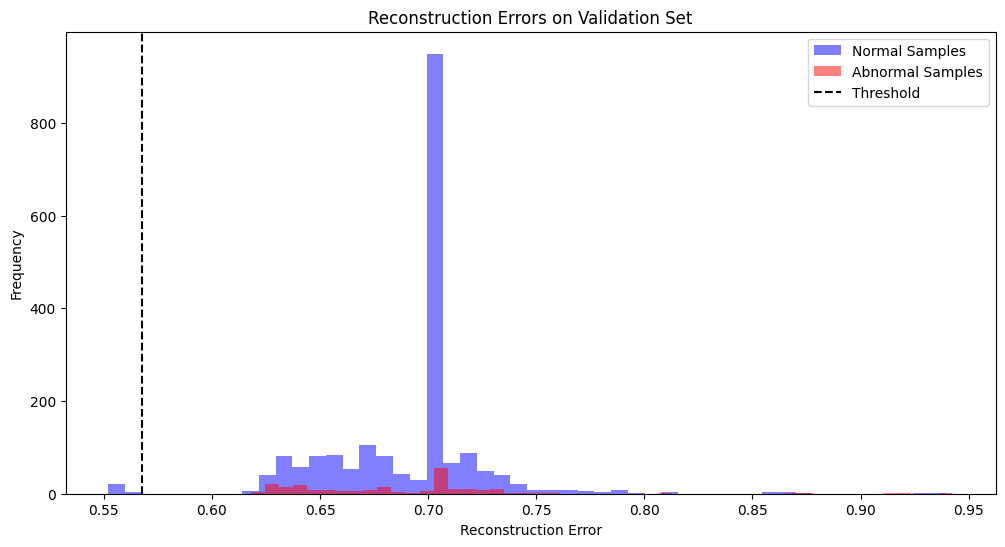

Best Threshold = 0.710130, Best F1 Score = 0.4444
Evaluation on Test Set:
Accuracy = 0.9044585987261147
Precision = 1.0
Recall = 0.2857142857142857
F1 Score = 0.4444444444444445
Confusion Matrix:
 [[136   0]
 [ 15   6]]
Fold 2
Epoch 1/15, Loss: 0.667248
Epoch 2/15, Loss: 0.628528
Epoch 3/15, Loss: 0.615419
Epoch 4/15, Loss: 0.612796
Epoch 5/15, Loss: 0.612023
Epoch 6/15, Loss: 0.611243
Epoch 7/15, Loss: 0.610425
Epoch 8/15, Loss: 0.609782
Epoch 9/15, Loss: 0.609445
Epoch 10/15, Loss: 0.609208
Epoch 11/15, Loss: 0.608979
Epoch 12/15, Loss: 0.608876
Epoch 13/15, Loss: 0.608767
Epoch 14/15, Loss: 0.608648
Epoch 15/15, Loss: 0.608576
Best threshold: 0.7096436047794843, Best F1 Score: 0.2483660130718954


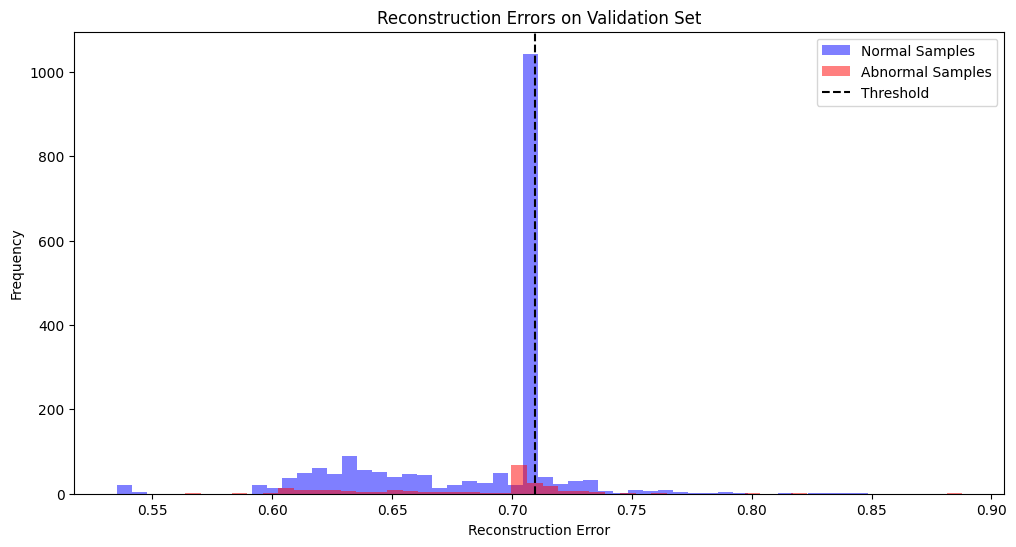

Best Threshold = 0.628340, Best F1 Score = 0.2260
Evaluation on Test Set:
Accuracy = 0.12738853503184713
Precision = 0.1282051282051282
Recall = 0.9523809523809523
F1 Score = 0.22598870056497172
Confusion Matrix:
 [[  0 136]
 [  1  20]]
Fold 3
Epoch 1/15, Loss: 0.661545
Epoch 2/15, Loss: 0.628006
Epoch 3/15, Loss: 0.616201
Epoch 4/15, Loss: 0.613968
Epoch 5/15, Loss: 0.613323
Epoch 6/15, Loss: 0.612301
Epoch 7/15, Loss: 0.610841
Epoch 8/15, Loss: 0.609995
Epoch 9/15, Loss: 0.609754
Epoch 10/15, Loss: 0.609664
Epoch 11/15, Loss: 0.609490
Epoch 12/15, Loss: 0.609392
Epoch 13/15, Loss: 0.609319
Epoch 14/15, Loss: 0.609205
Epoch 15/15, Loss: 0.609049
Best threshold: 0.599646999378397, Best F1 Score: 0.23006644518272423


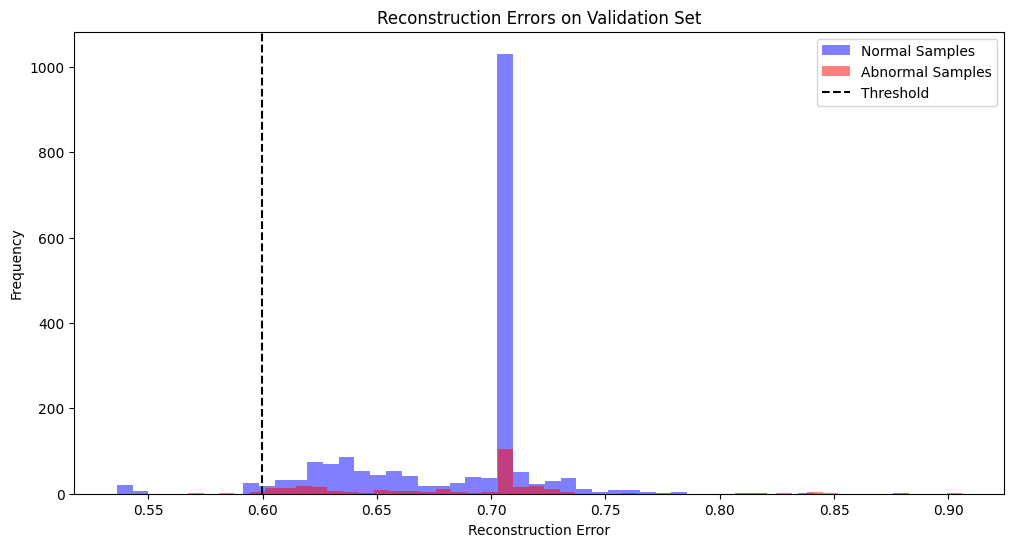

Best Threshold = 0.709390, Best F1 Score = 0.4000
Evaluation on Test Set:
Accuracy = 0.9230769230769231
Precision = 1.0
Recall = 0.25
F1 Score = 0.4
Confusion Matrix:
 [[140   0]
 [ 12   4]]
Fold 4
Epoch 1/15, Loss: 0.686322
Epoch 2/15, Loss: 0.620018
Epoch 3/15, Loss: 0.616107
Epoch 4/15, Loss: 0.615673
Epoch 5/15, Loss: 0.615269
Epoch 6/15, Loss: 0.613740
Epoch 7/15, Loss: 0.612537
Epoch 8/15, Loss: 0.612098
Epoch 9/15, Loss: 0.611878
Epoch 10/15, Loss: 0.611712
Epoch 11/15, Loss: 0.611583
Epoch 12/15, Loss: 0.611379
Epoch 13/15, Loss: 0.611197
Epoch 14/15, Loss: 0.611053
Epoch 15/15, Loss: 0.610891
Best threshold: 0.6012764085422863, Best F1 Score: 0.230514096185738


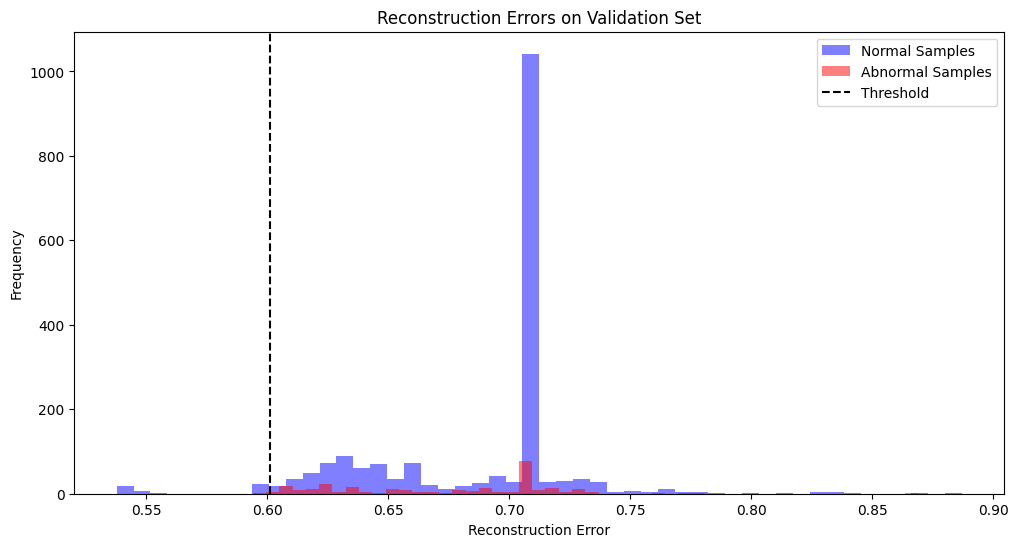

Best Threshold = 0.707879, Best F1 Score = 0.4348
Evaluation on Test Set:
Accuracy = 0.9166666666666666
Precision = 0.7142857142857143
Recall = 0.3125
F1 Score = 0.43478260869565216
Confusion Matrix:
 [[138   2]
 [ 11   5]]
Fold 5
Epoch 1/15, Loss: 0.691017
Epoch 2/15, Loss: 0.618271
Epoch 3/15, Loss: 0.616240
Epoch 4/15, Loss: 0.615860
Epoch 5/15, Loss: 0.615660
Epoch 6/15, Loss: 0.615480
Epoch 7/15, Loss: 0.615365
Epoch 8/15, Loss: 0.615320
Epoch 9/15, Loss: 0.615283
Epoch 10/15, Loss: 0.615183
Epoch 11/15, Loss: 0.615054
Epoch 12/15, Loss: 0.614677
Epoch 13/15, Loss: 0.613243
Epoch 14/15, Loss: 0.612254
Epoch 15/15, Loss: 0.612073
Best threshold: 0.553081705714717, Best F1 Score: 0.22988505747126434


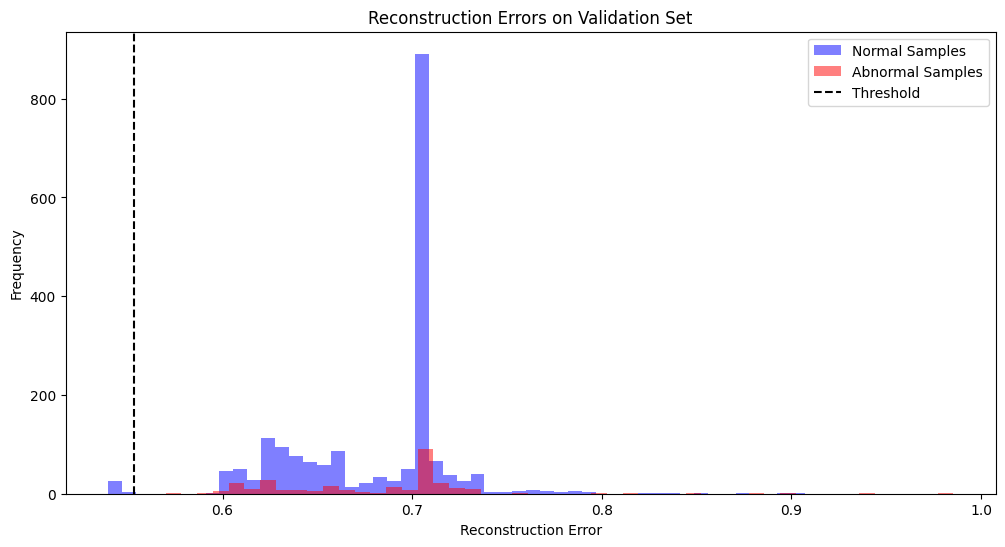

Best Threshold = 0.711272, Best F1 Score = 0.3158
Evaluation on Test Set:
Accuracy = 0.9166666666666666
Precision = 1.0
Recall = 0.1875
F1 Score = 0.3157894736842105
Confusion Matrix:
 [[140   0]
 [ 13   3]]


In [8]:

for fold, (train_idx, val_idx) in enumerate(skf.split(features, combine_label)):
    
    print(f"Fold {fold + 1}")
    
    # Get full fold data
    fold_data, fold_labels = features[train_idx], combine_label[train_idx]
    val_data, val_labels = features[val_idx], combine_label[val_idx]
   
    # Split into training and validation folds
    X_train, X_temp, y_train, y_temp = train_test_split(fold_data, fold_labels, test_size=0.2, shuffle=True, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(val_data, val_labels, test_size=0.5, shuffle=True, random_state=42)

    # Train autoencoder on the training fold
    model = train_autoencoder(X_train[y_train == 0], epochs=15, batch_size=32)

    # Evaluate on validation fold
    val_errors_normal = compute_reconstruction_loss(model, X_val[y_val == 0])
    val_errors_abnormal = compute_reconstruction_loss(model, X_val[y_val == 1])
    val_errors = np.concatenate([val_errors_normal, val_errors_abnormal])
    y_val_combined = np.concatenate([np.zeros(len(val_errors_normal)), np.ones(len(val_errors_abnormal))])
    
    threshold, best_f1 = find_best_threshold(val_errors, y_val_combined)
    print(f"Best threshold: {threshold}, Best F1 Score: {best_f1}")

    # Plot histogram of reconstruction errors on both normal and abnormal samples
    plt.figure(figsize=(12, 6))
    plt.hist(val_errors_normal, bins=50, alpha=0.5, label='Normal Samples', color='blue')
    plt.hist(val_errors_abnormal, bins=50, alpha=0.5, label='Abnormal Samples', color='red')
    plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
    plt.title('Reconstruction Errors on Validation Set')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    

    val_errors_test = compute_reconstruction_loss(model, X_test)
    

    # Evaluate on test set
    evaluate_on_test_with_threshold_search(model, X_test, y_test)



# Observation:

Accuracy = 0.9166666666666666


Precision = 0.7142857142857143

Recall = 0.3125

F1 Score = 0.43478260869565216

Confusion Matrix:

 [[138   2]

 [ 11   5]]



